In [141]:
import torch
import numpy as np
import zuko
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
_ = torch.random.manual_seed(0)
device = "cuda:0"

In [142]:
# prepare data
psd_data = np.load("results/stats/all_psd_stats.npy")
hr_data = np.load("results/stats/all_hr_stats.npy")
psd_data = torch.from_numpy(psd_data).float()
hr_data = torch.from_numpy(hr_data).float()

print(psd_data.shape, hr_data.shape)
print(psd_data.dtype, hr_data.dtype)

# build dataloader
trainset = data.TensorDataset(psd_data.to(device), hr_data.to(device))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)


torch.Size([47945, 129]) torch.Size([47945])
torch.float32 torch.float32


In [158]:
# TODO
# 1. balance psd loss
# 2. train flow model using smoothed psd data

# conditional flow
num_features = psd_data.shape[1]
flow = zuko.flows.NSF(features=num_features, context=1, transforms=3, hidden_features=(64, 64)).to(device)

# training
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
lr_history = []  # Track learning rates
def plot_lr_curve():
    plt.figure(figsize=(10, 3))
    plt.plot(lr_history)
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()


def psd_loss(psd_samples, hr_labels):
    low_pass = 45
    high_pass = 300
    freq_resolution = 2
    hr_indices = (hr_labels - low_pass) // freq_resolution
    hr_indices = hr_indices.long().squeeze()

    batch_size = psd_samples.shape[0]
    target_psd_powers = psd_samples[torch.arange(batch_size), hr_indices]
    differences = target_psd_powers.unsqueeze(dim=-1) - psd_samples
    hinge_loss = F.relu(-differences)

    return hinge_loss.sum(dim=1).mean()
    
losses = []
losses_nll = []
losses_psd = []
epoch_num = 8
for epoch_idx in range(epoch_num):
    losses_epoch = []
    for x, label in tqdm(trainloader, total=len(trainloader), desc=f"Epoch {epoch_idx}"):
        c = label.unsqueeze(dim=-1)

        loss_nll = -flow(c).log_prob(x).mean()
        if epoch_idx > 6:
            sampled_x = flow(c).sample() # shape: (batch_size, num_features), generate 1 sample for each condition
            loss_psd = psd_loss(sampled_x, c)
        else:
            loss_psd = torch.tensor(0.0).to(device)
        # print(f"loss_nll: {loss_nll.item()}, loss_psd: {loss_psd.item()}")
        loss = loss_nll + loss_psd
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        # Track current learning rate
        lr_history.append(optimizer.param_groups[0]['lr'])

        losses.append(loss.detach())
        losses_nll.append(loss_nll.detach())
        losses_psd.append(loss_psd.detach())
        losses_epoch.append(loss.detach())

    losses_epoch = torch.stack(losses_epoch)
    print(f"(epoch {epoch_idx})", losses_epoch.mean().item(), "±", losses_epoch.std().item())
    
    # Step the scheduler at the end of each epoch
    scheduler.step()

Epoch 0: 100%|██████████| 750/750 [00:03<00:00, 195.15it/s]


(epoch 0) -302.03033447265625 ± 84.00928497314453


Epoch 1: 100%|██████████| 750/750 [00:04<00:00, 182.07it/s]


(epoch 1) -416.73883056640625 ± 16.3753662109375


Epoch 2: 100%|██████████| 750/750 [00:03<00:00, 189.53it/s]


(epoch 2) -460.12738037109375 ± 11.670531272888184


Epoch 3: 100%|██████████| 750/750 [00:03<00:00, 197.21it/s]


(epoch 3) -490.1445007324219 ± 9.946911811828613


Epoch 4: 100%|██████████| 750/750 [00:03<00:00, 192.70it/s]


(epoch 4) -512.47119140625 ± 8.098783493041992


Epoch 5: 100%|██████████| 750/750 [00:03<00:00, 188.00it/s]


(epoch 5) -531.6464233398438 ± 7.964522361755371


Epoch 6: 100%|██████████| 750/750 [00:04<00:00, 182.69it/s]


(epoch 6) -547.083984375 ± 8.69650936126709


Epoch 7: 100%|██████████| 750/750 [01:53<00:00,  6.62it/s]

(epoch 7) -560.0550537109375 ± 8.149492263793945


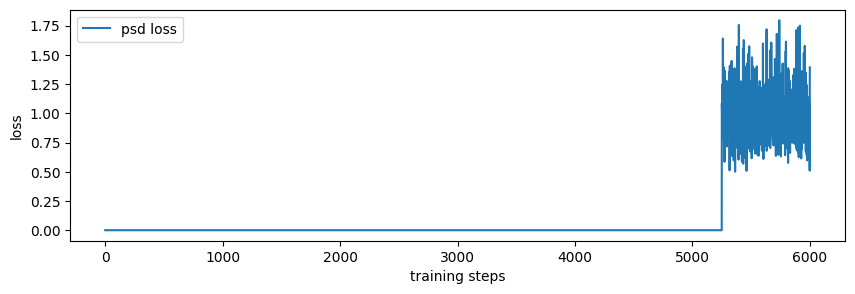

In [160]:
plt.figure(figsize=(10, 3))
# plt.plot(torch.stack(losses).detach().cpu().numpy(), label="total loss")
# plt.plot(torch.stack(losses_nll).detach().cpu().numpy(), label="nll loss")
plt.plot(torch.stack(losses_psd).detach().cpu().numpy(), label="psd loss")
plt.xlabel("training steps")
plt.ylabel("loss")
plt.legend()
plt.show()

torch.Size([10, 129])


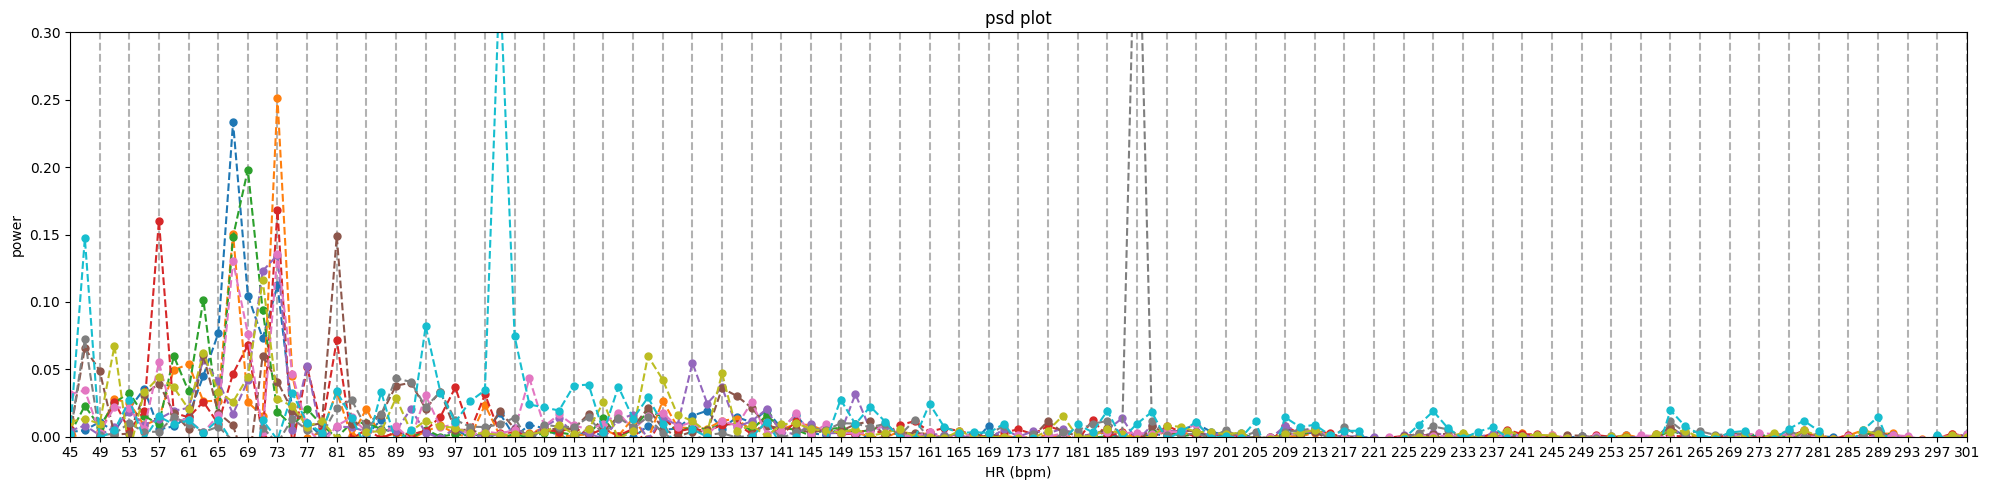

In [188]:
from evaluation.visualization import create_psd_figure, plot_psd

freq = np.arange(45, 300+2, 2)

target_hr = 61
psd_samples = flow(torch.tensor([target_hr]).to(device)).sample((10,))
print(psd_samples.shape)

psd_samples = psd_samples.detach().cpu().numpy()

create_psd_figure(xlim=[45, 300], xticks=np.arange(45, 300+2, 4))
for i in range(psd_samples.shape[0]):
    psd_sample = psd_samples[i]
    psd_sample = psd_sample / np.sum(psd_sample)
    plot_psd(freq, psd_sample)
plt.show()

In [176]:
psd_statistics = np.load("results/confidence_model/statistics/psd_statistics.npz")
psd_statistics




NpzFile 'results/confidence_model/statistics/psd_statistics.npz' with keys: psd_means, psd_covariances, sample_counts